In [2]:
import os, glob, sys
import numpy as np
import pandas as pd


In [ ]:

# ## Load all the data so we explore it. 
# pfile = '../Data/training_2024-11-04.pickle'
# pfile_test = '../Data/testing_2024-11-04.pickle'
# if os.path.isfile(pfile):
#   SEPSISdat = pd.DataFrame.from_dict(pd.read_pickle(pfile))
SEPSISdat = pd.read_excel('../Data/(new values added) final_cleared_training_data.xlsx')
print(len(SEPSISdat.patient)) # should be n=200112

# if os.path.isfile(pfile_test):
#   SEPSISdat_test = pd.DataFrame.from_dict(pd.read_pickle(pfile_test))
SEPSISdat_test = pd.read_excel('../Data/(new values added) final_cleared_testing_data.xlsx')
print(len(SEPSISdat_test.patient)) # should be n=41993

In [ ]:
# save data as pickle file

SEPSISdat.to_pickle('SEPSISdat.pkl')
SEPSISdat_test.to_pickle('SEPSISdat_test.pkl')

In [3]:
# load pickle files
SEPSISdat = pd.read_pickle('SEPSISdat.pkl')
SEPSISdat_test = pd.read_pickle('SEPSISdat_test.pkl')

In [4]:
SEPSISdat[SEPSISdat == '#DIV/0!'] = pd.NA
SEPSISdat_test[SEPSISdat_test == '#DIV/0!'] = pd.NA

In [5]:
## Forward-fill missing values
SEPSISdat.update(SEPSISdat.groupby('patient').ffill())
SEPSISdat_test.update(SEPSISdat_test.groupby('patient').ffill())

In [6]:
## Get reference ranges for variables using only non-sepsis patients as 'normal'
SEPSISdat_NOsepsis = SEPSISdat[~SEPSISdat.patient.isin(np.unique(SEPSISdat.patient[SEPSISdat.SepsisLabel==1]))]
SEPSISdat_NOsepsis = SEPSISdat_NOsepsis[SEPSISdat_NOsepsis.ICULOS>1]
SEPSISdat_NOsepsis.drop(['patient','SepsisLabel','Sex','sepsis_phase'],axis=1,inplace=True)
SEPSISdat_NOsepsis.astype('float')
meanSEPSISdat = round(SEPSISdat_NOsepsis.mean(axis=0),2)
sdSEPSISdat = round(SEPSISdat_NOsepsis.std(axis=0),2)
np.set_printoptions(suppress=True)
print('x_mean = np.array(')
print(np.array(meanSEPSISdat),')')
print('x_std = np.array(')
print(np.array(sdSEPSISdat),')')

x_mean = np.array(
[1.60260884620624 0.08533003033652327 -0.11890676812995411
 0.04653440526081911 0.10058764396060033 0.08061371290501503
 0.07201474848477317 0.13217113532663013 0.1019636695719023
 -0.1348934065960378 0.1660684494664233 -0.019481765593613868
 0.10048173028531106 0.07855411632348433 0.05872180578753183
 0.01595787363576427 0.04271369132033448 -0.05769599567420747
 -0.15415396446552215 -0.1681203856282934 0.03162877348068991
 -0.1116294717893621 0.020859625714503678 0.0731099922636377
 0.1376940317470291 0.007103212308487817 0.12157717793197748
 -0.013779591465311153] )
x_std = np.array(
[0.9911891812700238 1.0141954469325383 1.0145332283566566
 0.9715413606172714 1.030110617713914 1.0230309640860955
 1.0454030714551494 1.0128985433465714 1.0741308602691924 1.05318839801914
 1.0416095155784757 1.0636669806701329 1.0984317617893318
 0.8721621100504063 1.0590037332960398 0.9998077072589092
 0.9652738462104572 0.9423149842216582 0.9477444205634864
 0.9592769381727284 1.05

In [7]:
## Obtain the z-scores for all the variables
SEPSISdat_zScores = SEPSISdat
SEPSISdat_test_zScores = SEPSISdat_test
cols = SEPSISdat_zScores.columns.drop(['patient','SepsisLabel','Sex','sepsis_phase'])
for c in cols:
  SEPSISdat_zScores[c] = (SEPSISdat_zScores[c]-meanSEPSISdat[c])/sdSEPSISdat[c]
  SEPSISdat_test_zScores[c] = (SEPSISdat_test_zScores[c]-meanSEPSISdat[c])/sdSEPSISdat[c]

In [8]:
## Replace values still missing with the mean
SEPSISdat_zScores = SEPSISdat_zScores.fillna(0)
SEPSISdat_test_zScores = SEPSISdat_test_zScores.fillna(0)

C:\Users\Rex\AppData\Local\Temp\ipykernel_13576\3534544806.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  SEPSISdat_zScores = SEPSISdat_zScores.fillna(0)
C:\Users\Rex\AppData\Local\Temp\ipykernel_13576\3534544806.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  SEPSISdat_test_zScores = SEPSISdat_test_zScores.fillna(0)


In [9]:
#### OPTION 1: LOGISTIC REGRESSION ####
## Build a logistic regression using all the training data
y = SEPSISdat_zScores.SepsisLabel
X = SEPSISdat_zScores.copy()
X.drop(['patient','SepsisLabel','sepsis_phase'],axis=1,inplace=True)
y_test = SEPSISdat_test_zScores.SepsisLabel
X_test = SEPSISdat_test_zScores.copy()
X_test.drop(['patient','SepsisLabel','sepsis_phase'],axis=1,inplace=True)


In [8]:

from sklearn.linear_model import SGDClassifier
lreg = SGDClassifier(loss='log_loss', penalty='l1')
lreg.fit(X,y)
print('const=',np.round(lreg.intercept_,4))
print('coeffs = np.array(')
print(np.round(lreg.coef_,4),')')


const= [-4.139]
coeffs = np.array(
[[ 0.1468  0.0079  0.      0.4669  0.     -0.2395  0.0546  0.0933  0.0801
   0.0459  0.      0.      0.102  -0.1876  0.1509  0.0988  0.     -0.1467
  -0.2152  0.1908  0.1286  0.0945  0.      0.0391 -0.1658  0.      0.
  -0.003  -0.0023]] )


In [14]:

## Add the predictions [Note: column 1 is the filename, which you don't get to see in the scoring and isn't helpful otherwise here]
# X = X.assign(probSepsisLR=lreg.predict_proba(X.iloc)[::,1])
# X_test = X_test.assign(probSepsisLR=lreg.predict_proba(SEPSISdat_test_zScores.iloc[:,1:24])[::,1])
y_prob = lreg.predict_proba(X)[:,1]
y_test_prob = lreg.predict_proba(X_test)[:,1]
#print(SEPSISdat_zScores)


AUC: 0.739
AUC_test: 0.715
thresh= 0.0299


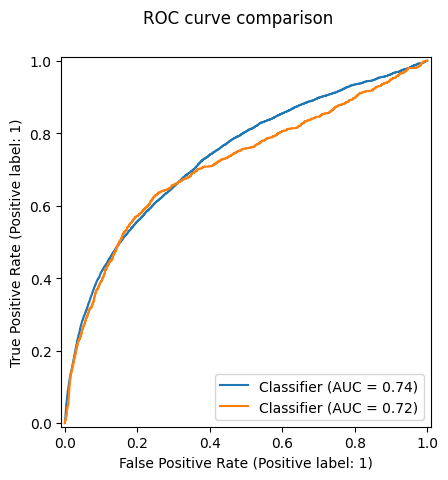

In [15]:

## Quick but not necessarily great way to find a threshold. Also calculate the AUC
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y,y_prob)
fpr1, tpr1, thresholds1 = roc_curve(y_test,y_test_prob)
train_disp=RocCurveDisplay.from_predictions(y,y_prob)
test_disp=RocCurveDisplay.from_predictions(y_test,y_test_prob, ax=train_disp.ax_)
train_disp.figure_.suptitle("ROC curve comparison")
print('AUC:',round(roc_auc_score(y,y_prob),3))
print('AUC_test:',round(roc_auc_score(y_test,y_test_prob),3))
thresh=round(thresholds[np.argmax(tpr - fpr)],4)
print('thresh=',thresh)

In [16]:
# Quick calculation of utility score
y_pred = (y_prob>thresh).astype(int)
y_test_pred = (y_test_prob>thresh).astype(int)

import evaluate_sepsis_score as ev
util = ev.evaluate_utility(SEPSISdat.patient,np.array(y),np.array(y_pred))
print(util)
util_test = ev.evaluate_utility(SEPSISdat_test.patient,np.array(y_test),np.array(y_test_pred))
print(util_test)

100%|██████████| 5000/5000 [03:02<00:00, 27.41it/s]


0.3426


100%|██████████| 1000/1000 [00:07<00:00, 131.43it/s]

0.3405


In [64]:
#### OPTION 2: BOOSTED TREE #####
## Build a LightGBM model using all the training data
import lightgbm as lgb
train_data = lgb.Dataset(data=X, label=y)
param = {'objective': 'binary'}
bst = lgb.train(param, train_data, 10)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5303, number of negative: 194809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 200112, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026500 -> initscore=-3.603747
[LightGBM] [Info] Start training from score -3.603747


In [ ]:

## Add the predictions [Note: column 1 is the filename, which you don't get to see in the scoring and isn't helpful otherwise here]
y_prob = bst.predict(data=X)
y_test_prob = bst.predict(data=X_test)


AUC: 0.847
AUC_test: 0.732
Threshold: 0.0359


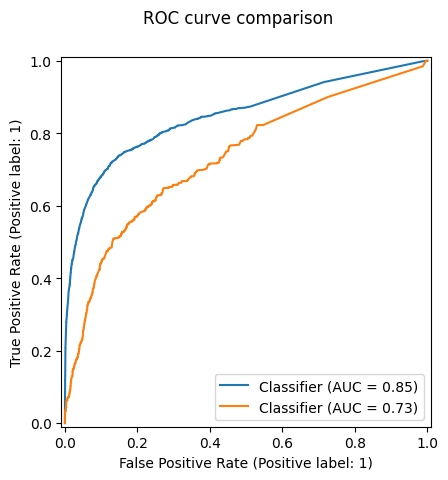

In [ ]:

## Quick but not necessarily great way to find a threshold. Also calculate the AUC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y,y_prob)
fpr1, tpr1, thresholds1 = roc_curve(y_test,y_test_prob)
train_disp=RocCurveDisplay.from_predictions(y,y_prob)
test_disp=RocCurveDisplay.from_predictions(y_test,y_test_prob, ax=train_disp.ax_)
train_disp.figure_.suptitle("ROC curve comparison")

print('AUC:',round(roc_auc_score(y,y_prob),3))
print('AUC_test:',round(roc_auc_score(y_test,y_test_prob),3))

# Save the model and get the threshold for use as a model
bst.save_model('lightgbm.model')
thresh=round(thresholds[np.argmax(tpr - fpr)],4)
print('Threshold:',thresh)

In [ ]:
# Quick calculation of utility score
y_pred = (y_prob>thresh).astype(int)
y_test_pred = (y_test_prob>thresh).astype(int)

import evaluate_sepsis_score as ev
util = ev.evaluate_utility(SEPSISdat.patient,np.array(y),np.array(y_pred))
print(util)
util_test = ev.evaluate_utility(SEPSISdat_test.patient,np.array(y_test),np.array(y_test_pred))
print(util_test)

100%|█████████████████████████████████████████████████████████| 5000/5000 [03:15<00:00, 25.53it/s]


0.5076


100%|████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.55it/s]

0.3339


In [ ]:
## OPTION 4: Support Vector Machine ##
exit(0)
from sklearn import svm
clf = svm.LinearSVC(max_iter=3000)
clf.fit(X,y)

## Add the predictions
y_prob = clf.predict(X)
y_test_prob = clf.predict(X_test)

## Quick but not necessarily great way to find a threshold. Also calculate the AUC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y, y_prob)
print('AUC:',round(roc_auc_score(y,y_prob),2))
print('AUC_test:',round(roc_auc_score(y_test, y_test_prob),2))
thresh=round(thresholds[np.argmax(tpr - fpr)],4)
print('Threshold:',thresh)

# # Quick calculation of utility score
# SEPSISdat = SEPSISdat.assign(SepsisLabelSVM = (SEPSISdat_zScores.probSepsisSVM>thresh).astype(int))
# SEPSISdat_test= SEPSISdat_test.assign(SepsisLabelSVM = (SEPSISdat_test_zScores.probSepsisSVM>thresh).astype(int))

# import evaluate_sepsis_score as ev
# util = ev.evaluate_utility(SEPSISdat.patient,np.array(SEPSISdat_zScores.SepsisLabel),np.array(SEPSISdat.SepsisLabelSVM))
# print(util)
# util_test = ev.evaluate_utility(SEPSISdat_test.patient,np.array(SEPSISdat_test_zScores.SepsisLabel),np.array(SEPSISdat_test.SepsisLabelSVM))
# print(util_test)

# Quick calculation of utility score
y_pred = (y_prob>thresh).astype(int)
y_test_pred = (y_test_prob>thresh).astype(int)

import evaluate_sepsis_score as ev
util = ev.evaluate_utility(SEPSISdat.patient,np.array(y),np.array(y_pred))
print(util)
util_test = ev.evaluate_utility(SEPSISdat_test.patient,np.array(y_test),np.array(y_test_pred))
print(util_test)

AUC: 0.5
AUC_test: 0.5
Threshold: inf


 64%|██████▎   | 3183/5000 [01:59<01:08, 26.67it/s]


KeyboardInterrupt: 

: 

AUC: 0.924
AUC_test: 0.525


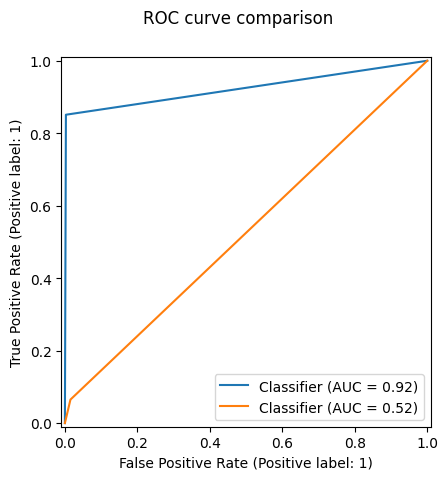

: 

In [ ]:
## OPTION 3: KNN Classifier ##
exit(0)
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X,y)

## Add the predictions
y_prob=model.predict(X)
y_test_prob = model.predict(X_test)

## Quick but not necessarily great way to find a threshold. Also calculate the AUC
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y,y_prob)
fpr1, tpr1, thresholds1 = roc_curve(y_test,y_test_prob)
train_disp=RocCurveDisplay.from_predictions(y,y_prob)
test_disp=RocCurveDisplay.from_predictions(y_test,y_test_prob, ax=train_disp.ax_)
train_disp.figure_.suptitle("ROC curve comparison")

print('AUC:',round(roc_auc_score(y,y_prob),3))
print('AUC_test:',round(roc_auc_score(y_test,y_test_prob),3))

In [ ]:
# Quick calculation of utility score
SEPSISdat = SEPSISdat.assign(SepsisLabelKNN = (SEPSISdat_zScores.probSepsisKNN>thresh).astype(int))
SEPSISdat_test= SEPSISdat_test.assign(SepsisLabelKNN = (SEPSISdat_test_zScores.probSepsisKNN>thresh).astype(int))

import evaluate_sepsis_score as ev
util = ev.evaluate_utility(SEPSISdat.patient,np.array(SEPSISdat_zScores.SepsisLabel),np.array(SEPSISdat.SepsisLabelKNN))
print(util)
util_test = ev.evaluate_utility(SEPSISdat_test.patient,np.array(SEPSISdat_test_zScores.SepsisLabel),np.array(SEPSISdat_test.SepsisLabelKNN))
print(util_test)

In [ ]:
#### Random Forest ####
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X, y)


NameError: name 'lreg' is not defined

In [ ]:

y_prob = rf.predict_proba(X)[:,1]
y_test_prob = rf.predict_proba(X_test)[:,1]


NameError: name 'RocCurveDisplay' is not defined

AUC: 1.0
AUC_test: 0.72
Threshold: 0.55


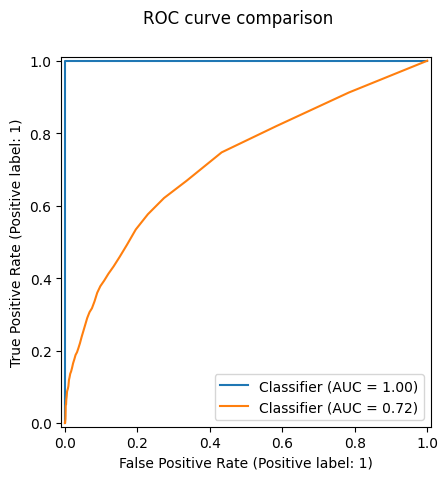

In [15]:

## Quick but not necessarily great way to find a threshold. Also calculate the AUC
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y,y_prob)
fpr1, tpr1, thresholds1 = roc_curve(y_test,y_test_prob)
train_disp=RocCurveDisplay.from_predictions(y,y_prob)
test_disp=RocCurveDisplay.from_predictions(y_test,y_test_prob, ax=train_disp.ax_)
train_disp.figure_.suptitle("ROC curve comparison")

print('AUC:',round(roc_auc_score(y,y_prob),3))
print('AUC_test:',round(roc_auc_score(y_test,y_test_prob),3))


# Save the model and get the threshold for use as a model
# rf.save_model('lightgbm.model')
thresh=round(thresholds[np.argmax(tpr - fpr)],4)
print('Threshold:',thresh)